In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
import cv2
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention,LayerNormalization,Embedding,MaxPool2D,Add,Activation,GlobalAveragePooling2D,Conv2D,Dense,MaxPooling2D,Flatten,InputLayer,BatchNormalization,Input,Layer,Dropout,RandomFlip,RandomRotation,Resizing,Rescaling,RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy,FalseNegatives,FalsePositives,TrueNegatives,TruePositives,Precision,Recall,AUC
from tensorflow.keras.metrics import SparseCategoricalAccuracy,SparseTopKCategoricalAccuracy
import sklearn
import albumentations as A
from albumentations.augmentations import CoarseDropout 
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.train import BytesList,Int64List,FloatList
from tensorflow.train import Example,Feature,Features

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
train_dir = r"D:\DeepLearning\TensorFlow\Human Emotions Detection\Emotions Dataset\Emotions Dataset\train"
val_dir = r"D:\DeepLearning\TensorFlow\Human Emotions Detection\Emotions Dataset\Emotions Dataset\test"
class_names = ['angry','happy','sad']

In [4]:
configuration ={'Batch size':32,
               'IM_size':256}

In [5]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [6]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 2280 files belonging to 3 classes.


In [7]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.1900000e+02, 1.1900000e+02, 1.1900000e+02],
         [1.1900000e+02, 1.1900000e+02, 1.1900000e+02],
         [1.1762500e+02, 1.1762500e+02, 1.1762500e+02],
         ...,
         [5.5312500e+01, 5.5312500e+01, 5.5312500e+01],
         [5.6000000e+01, 5.6000000e+01, 5.6000000e+01],
         [5.6000000e+01, 5.6000000e+01, 5.6000000e+01]],

        [[1.1818750e+02, 1.1818750e+02, 1.1818750e+02],
         [1.1884766e+02, 1.1884766e+02, 1.1884766e+02],
         [1.1762500e+02, 1.1762500e+02, 1.1762500e+02],
         ...,
         [5.7750000e+01, 5.7750000e+01, 5.7750000e+01],
         [5.8437500e+01, 5.8437500e+01, 5.8437500e+01],
         [5.8437500e+01, 5.8437500e+01, 5.8437500e+01]],

        [[1.1800000e+02, 1.1800000e+02, 1.1800000e+02],
         [1.1881250e+02, 1.1881250e+02, 1.1881250e+02],
         [1.1762500e+02, 1.1762500e+02, 1.1762500e+02],
         ...,
         [6.0847656e+01, 6.0847656e+01, 6.0847656e+01]

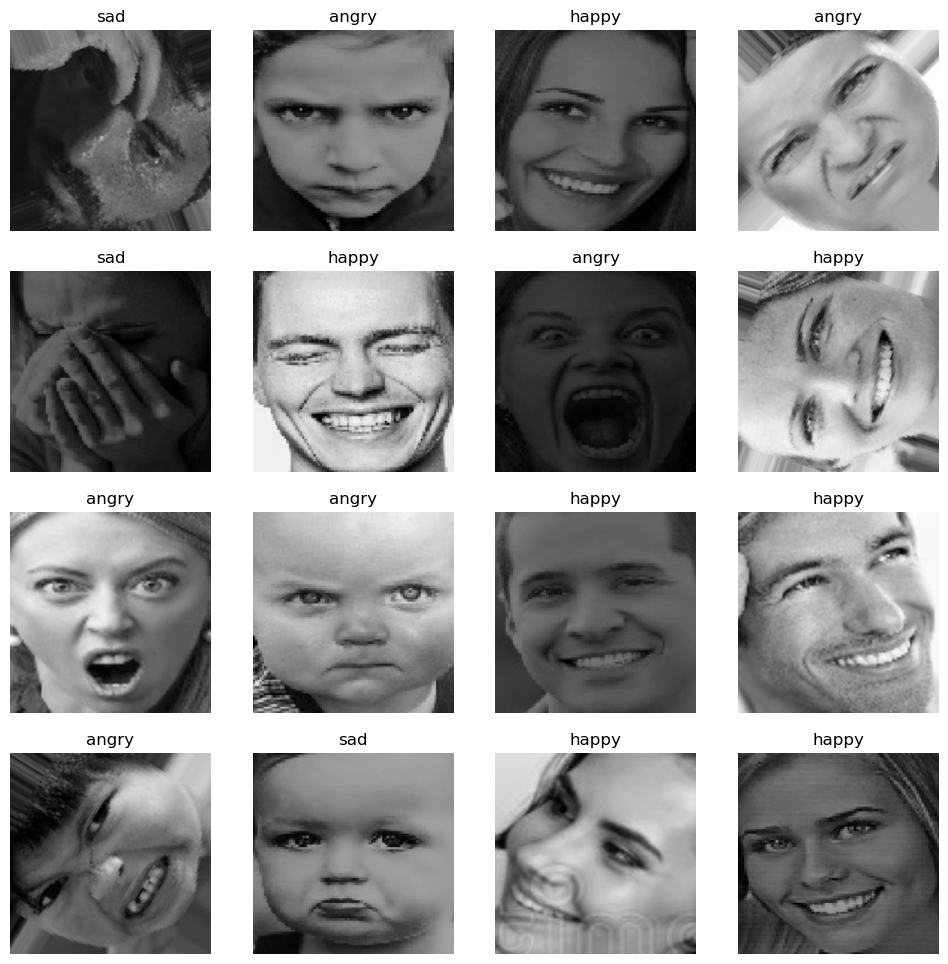

In [8]:
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis('off')

## Data Preprocessing

In [10]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(configuration['IM_size'],configuration['IM_size']),
    Rescaling(1.0/225)])
def resize_rescale_layer(image,label):
    return resize_rescale_layers(image,training =True),label

In [11]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25,0.2501)),
    RandomFlip(mode='horizontal',)])
def augment_layer(image,label):
    return augment_layers(image,training =True),label

In [12]:
def box(lamda):
    
    r_x = tf.cast(tfp.distributions.Uniform(0,CONFIGURATION['IM_SIZE']).sample(1)[0],dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0,CONFIGURATION['IM_SIZE']).sample(1)[0],dtype = tf.int32)

    r_w = tf.cast(CONFIGURATION['IM_SIZE']*tf.math.sqrt(1-lamda),dtype=tf.int32)
    r_h = tf.cast(CONFIGURATION['IM_SIZE']*tf.math.sqrt(1-lamda),dtype=tf.int32)

    r_x = tf.clip_by_value(r_x -r_w//2,0,CONFIGURATION['IM_SIZE'])
    r_y = tf.clip_by_value(r_y -r_h//2,0,CONFIGURATION['IM_SIZE'])

    x_b_r = tf.clip_by_value(r_x +r_w//2,0,CONFIGURATION['IM_SIZE'])
    y_b_r = tf.clip_by_value(r_y +r_h//2,0,CONFIGURATION['IM_SIZE'])

    r_w = x_b_r - r_x
    if(r_w ==0):
        r_w=1
    r_h = y_b_r - r_y
    if(r_h ==0):
        r_h=1
    return r_x,r_y,r_w,r_h 

In [13]:
def cutmix(train_dataset_1,train_dataset_2):
    (image_1,label_1),(image_2,label_2) = train_dataset_1,train_dataset_2
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    r_x,r_y,r_w,r_h = box(lamda)

    crop_2 = tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
    
    pad_2 = tf.image.pad_to_bounding_box(crop_2,r_y,r_x,CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'])

    crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'])

    image = image_1-pad_1+pad_2  
    lamda = tf.cast(1 -(r_w*r_h)/(CONFIGURATION['IM_SIZE']**2),dtype = tf.float32)
    label = lamda*tf.cast(label_1,dtype = tf.float32)+(1-lamda)*tf.cast(label_2,dtype = tf.float32)
    return image,label

In [14]:
# train_dataset_1 = train_dataset.map(augment_layer)
# train_dataset_2 = train_dataset.map(augment_layer)

# mix_dataset = tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [15]:
training_dataset = (train_dataset
                    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
                    )

In [16]:
validation_dataset = (val_dataset
                      )

### TFRecords

In [17]:
# training_dataset = (training_dataset
#                     .unbatch()
#                    )

In [18]:
# validation_dataset = (validation_dataset
#                       .unbatch())

In [19]:
def create_example(image,label):
    
    bytes_feature = Feature(
        bytes_list=BytesList(value=[image]))
    int_feature = Feature(
        int64_list=Int64List(value=[label]))
    example = Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,
        }))

    return example.SerializeToString()

In [20]:
N_Shards = 10
path = 'tfrecords/shard_{:02d}.tfrecord'

In [21]:
def encode_image(image,label):
    image = tf.image.convert_image_dtype(image,dtype = tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image,tf.argmax(label)

In [22]:
# encoded_dataset = (
#     training_dataset
#     .map(encode_image)
    
# )

In [23]:
# for shard_number in range(N_Shards):
#     shard_dataset=(encoded_dataset
#                    .shard(N_Shards,shard_number)
#                   .as_numpy_iterator())
#     with tf.io.TFRecordWriter(path.format(shard_number)) as file_writer:
#       for image,label in shard_dataset:
#         file_writer.write(create_example(image,label))

In [24]:
# recons_dataset = tf.data.TFRecordDataset(
#     filenames=[path.format(p) for  p in range(N_Shards)]
# )

In [25]:
# def parse_tfrecords(example):
#     feature_desription={
#         'images':tf.io.FixedLenFeature([],tf.string),
#         'labels':tf.io.FixedLenFeature([],tf.int64)
#     }
#     example = tf.io.parse_single_example(example,feature_desription)
#     example['images']=tf.io.decode_jpeg(example['images'],channels = 3)
#     return example['images'],example['labels']

In [26]:
# parsed_dataset=(
#     recons_dataset
#     .map(parse_tfrecords)
#     .batch(32)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [27]:
# for i in parsed_dataset.take(1):
#     print(i)

## Model

In [28]:
model = tf.keras.Sequential(
    [
    InputLayer(shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [29]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [30]:
model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = CategoricalCrossentropy(),
  metrics = metrics,
)

In [31]:
history=model.fit( 
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.4902 - loss: 1.1539 - top_k_accuracy: 0.7795 - val_accuracy: 0.3323 - val_loss: 1.2380 - val_top_k_accuracy: 0.7739
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6658 - loss: 0.7669 - top_k_accuracy: 0.8900 - val_accuracy: 0.4917 - val_loss: 1.1646 - val_top_k_accuracy: 0.7748
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7509 - loss: 0.6128 - top_k_accuracy: 0.9215 - val_accuracy: 0.4974 - val_loss: 1.1837 - val_top_k_accuracy: 0.8011
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.8202 - loss: 0.4622 - top_k_accuracy: 0.9527 - val_accuracy: 0.5356 - val_loss: 1.2435 - val_top_k_accuracy: 0.7963
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.8609 - loss: 0.3910 - top_k_accuracy: 0.9612 - val_accuracy: 0.5189 - val_loss: 1.3235 - val_top_k_accuracy: 0.8152


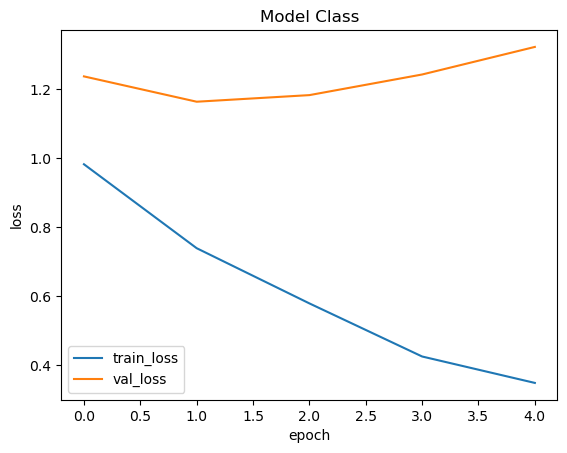

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Class')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

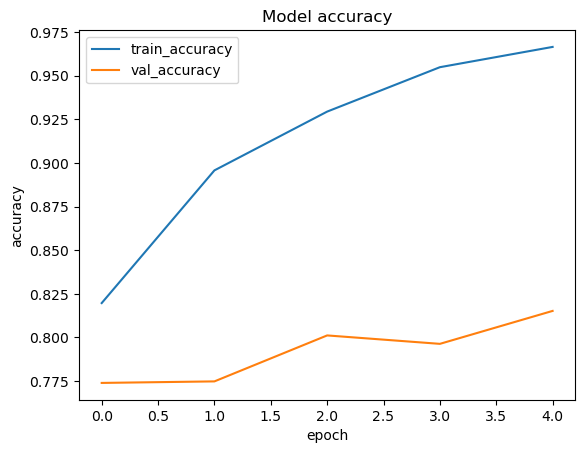

In [33]:
plt.plot(history.history['top_k_accuracy'])
plt.plot(history.history['val_top_k_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [34]:
model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.5173 - loss: 1.3348 - top_k_accuracy: 0.8158


[1.3234853744506836, 0.5188761949539185, 0.8151887655258179]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


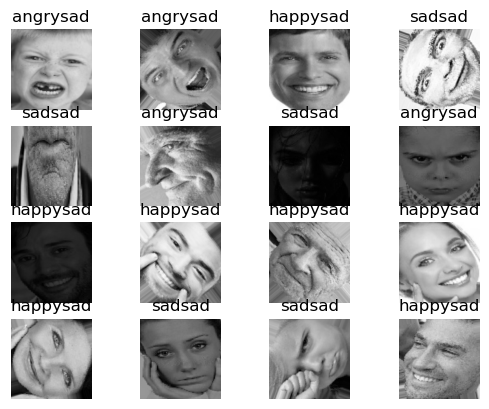

In [35]:
for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i],axis=0).numpy()]+class_names[tf.argmax(model.predict(images),axis=-1).numpy()[0]])
        plt.axis('off')

In [70]:
predicted = []
labels = []

for im,label in validation_dataset:
    predicted.append(model(im))
    labels.append(label)

In [71]:
len(labels[:-1])

71

In [72]:
lab = np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()],axis=0)
pred = np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()],axis = 0)

[[198 101 216]
 [141 569 296]
 [179 160 418]]


Text(0.5, 14.722222222222216, 'predicted')

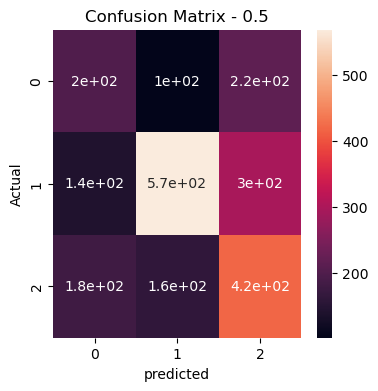

In [73]:
threshold = 0.5
cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(4,4))

sns.heatmap(cm,annot=True,)
plt.title(f'Confusion Matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('predicted')

## ResNet

In [48]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = False):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x

In [49]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input,training= training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [50]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [51]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]),training = True)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 63, 63, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [52]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [53]:
resnet_34.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
  loss = CategoricalCrossentropy(),
  metrics = metrics,
)

In [54]:
history=resnet_34.fit( 
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 2823s 13s/step - accuracy: 0.3916 - loss: 2.1708 - top_k_accuracy: 0.7210 - val_accuracy: 0.3499 - val_loss: 20.4280 - val_top_k_accuracy: 0.6615
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1355s 6s/step - accuracy: 0.4825 - loss: 1.1251 - top_k_accuracy: 0.7584 - val_accuracy: 0.4701 - val_loss: 1.2742 - val_top_k_accuracy: 0.7406
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1399s 7s/step - accuracy: 0.4665 - loss: 1.0665 - top_k_accuracy: 0.7634 - val_accuracy: 0.4868 - val_loss: 1.0912 - val_top_k_accuracy: 0.7695
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 4292s 20s/step - accuracy: 0.5178 - loss: 1.0010 - top_k_accuracy: 0.7957 - val_accuracy: 0.4460 - val_loss: 1.3993 - val_top_k_accuracy: 0.7173
Epoch 5/5
123/213 ━━━━━━━━━━━━━━━━━━━━ 31:57 21s/step - accuracy: 0.5307 - loss: 0.9906 - top_k_accuracy: 0.8026

KeyboardInterrupt: 

## Transfer learning

In [74]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
)

In [75]:
backbone.trainable = False

In [76]:
model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'],activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'],activation='relu'),
    Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax'),
    
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [77]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [82]:
model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = CategoricalCrossentropy(),
  metrics = metrics,
)

In [65]:
history=model.fit( 
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5861 - loss: 1.1082 - top_k_accuracy: 0.8469 - val_accuracy: 0.6580 - val_loss: 0.7712 - val_top_k_accuracy: 0.8986
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.7156 - loss: 0.6726 - top_k_accuracy: 0.9145 - val_accuracy: 0.6703 - val_loss: 0.8066 - val_top_k_accuracy: 0.8942
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.7713 - loss: 0.5532 - top_k_accuracy: 0.9354 - val_accuracy: 0.7059 - val_loss: 0.7092 - val_top_k_accuracy: 0.9061
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.8019 - loss: 0.4915 - top_k_accuracy: 0.9498 - val_accuracy: 0.6782 - val_loss: 0.8993 - val_top_k_accuracy: 0.8885
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8115 - loss: 0.4564 - top_k_accuracy: 0.9491 - val_accuracy: 0.7024 - val_loss: 0.7687 - val_top_k_accuracy: 0.8964


## FineTuning

In [67]:
backbone.trainable = False

In [71]:
input = Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))
x = backbone(input,training =False)
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION['N_DENSE_1'],activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION['N_DENSE_2'],activation='relu')(x)
output = Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax')(x)

finetune_model = Model(input,output)

In [73]:
finetune_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

## Feature Maps

In [54]:
vgg_backbone = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),

)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 33s 1us/step


In [55]:
vgg_backbone.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name) == True]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)
feature_map_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
def is_conv(layer_name):
    if conv in layer_name :
        return True
    else:
        False

In [78]:
test_im = cv2.imread('100610.jpg_brightness_1.jpg')
if test_im is None:
    print(f"Error: Could not read the image from the path:")
test_im = cv2.resize(test_im,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = tf.constant(test_im , dtype = tf.float32)
im = tf.expand_dims(im,axis=0)

f_maps = feature_map_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


In [98]:
(f_maps[0].shape)

(1, 256, 256, 64)

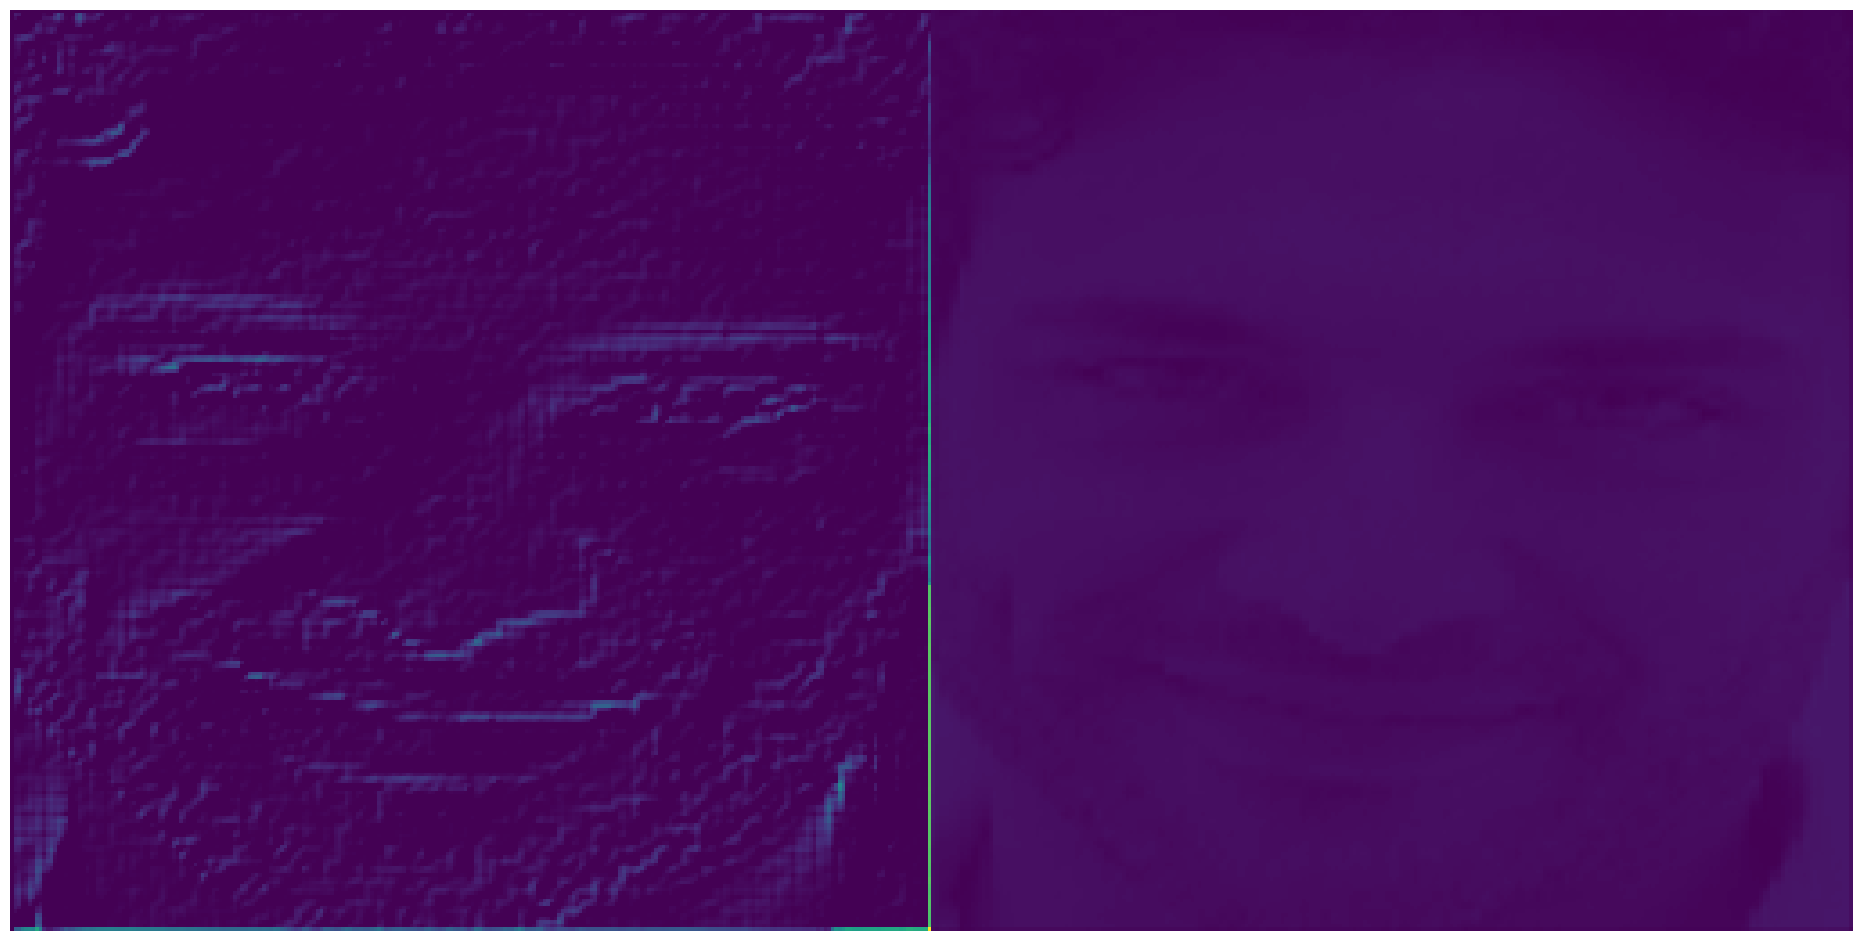

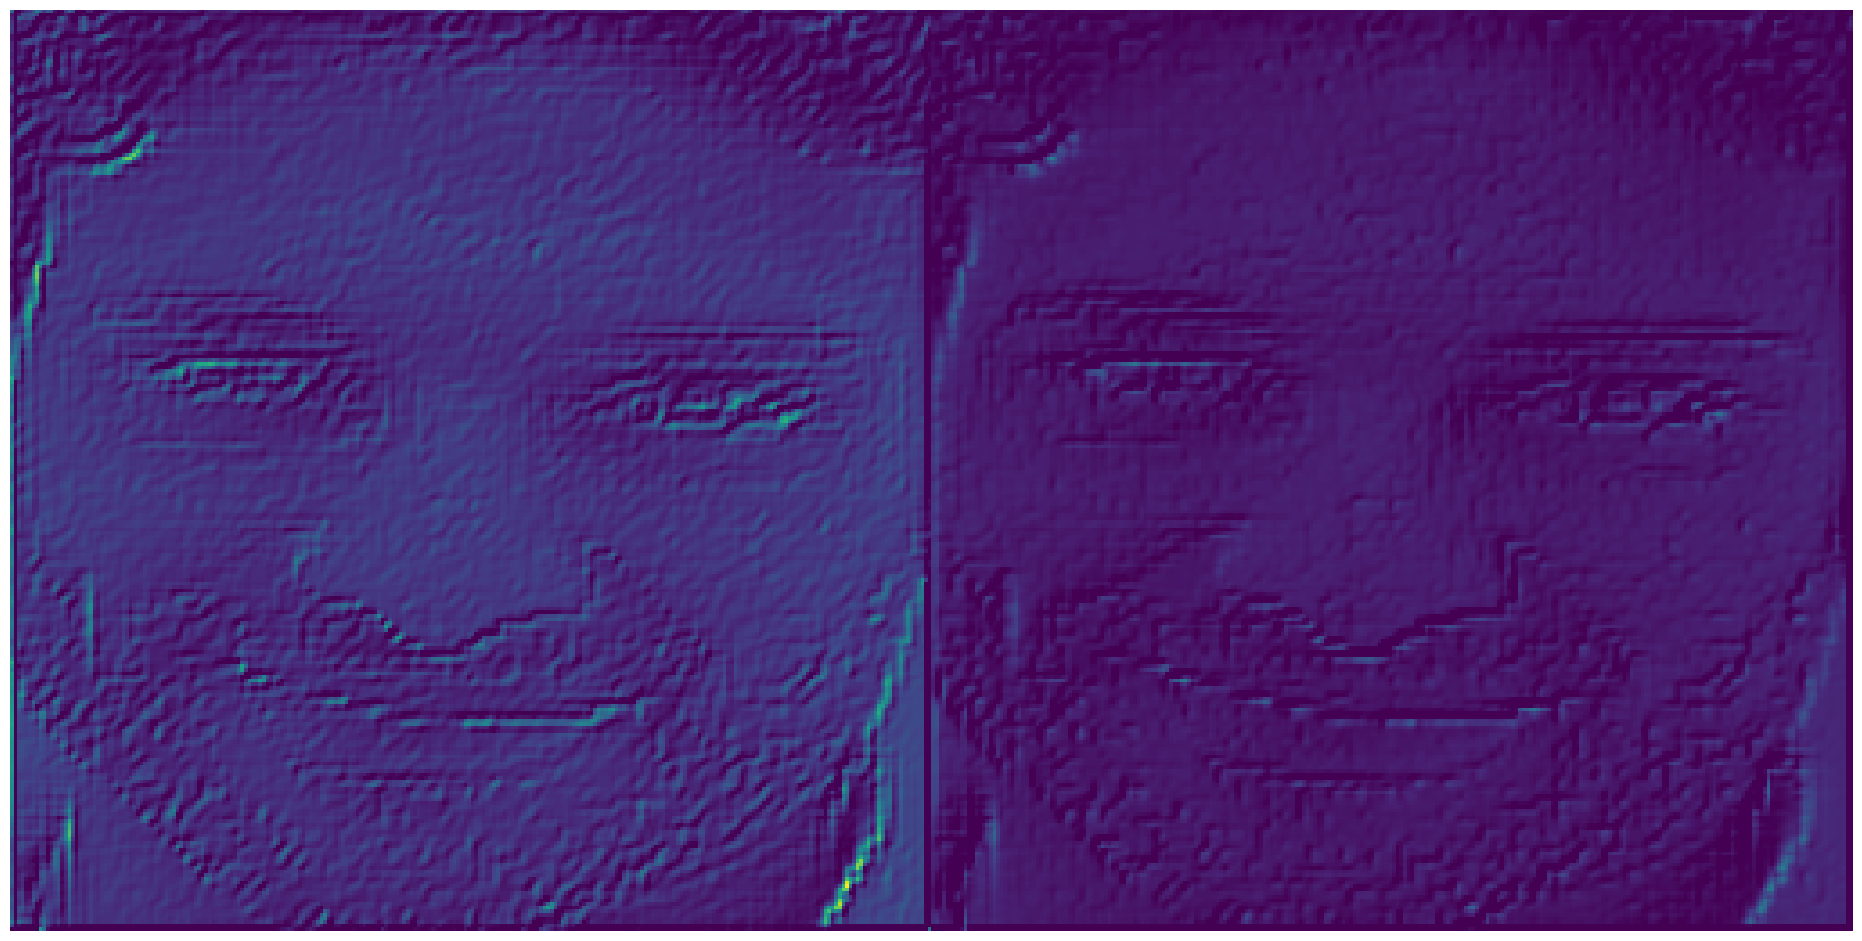

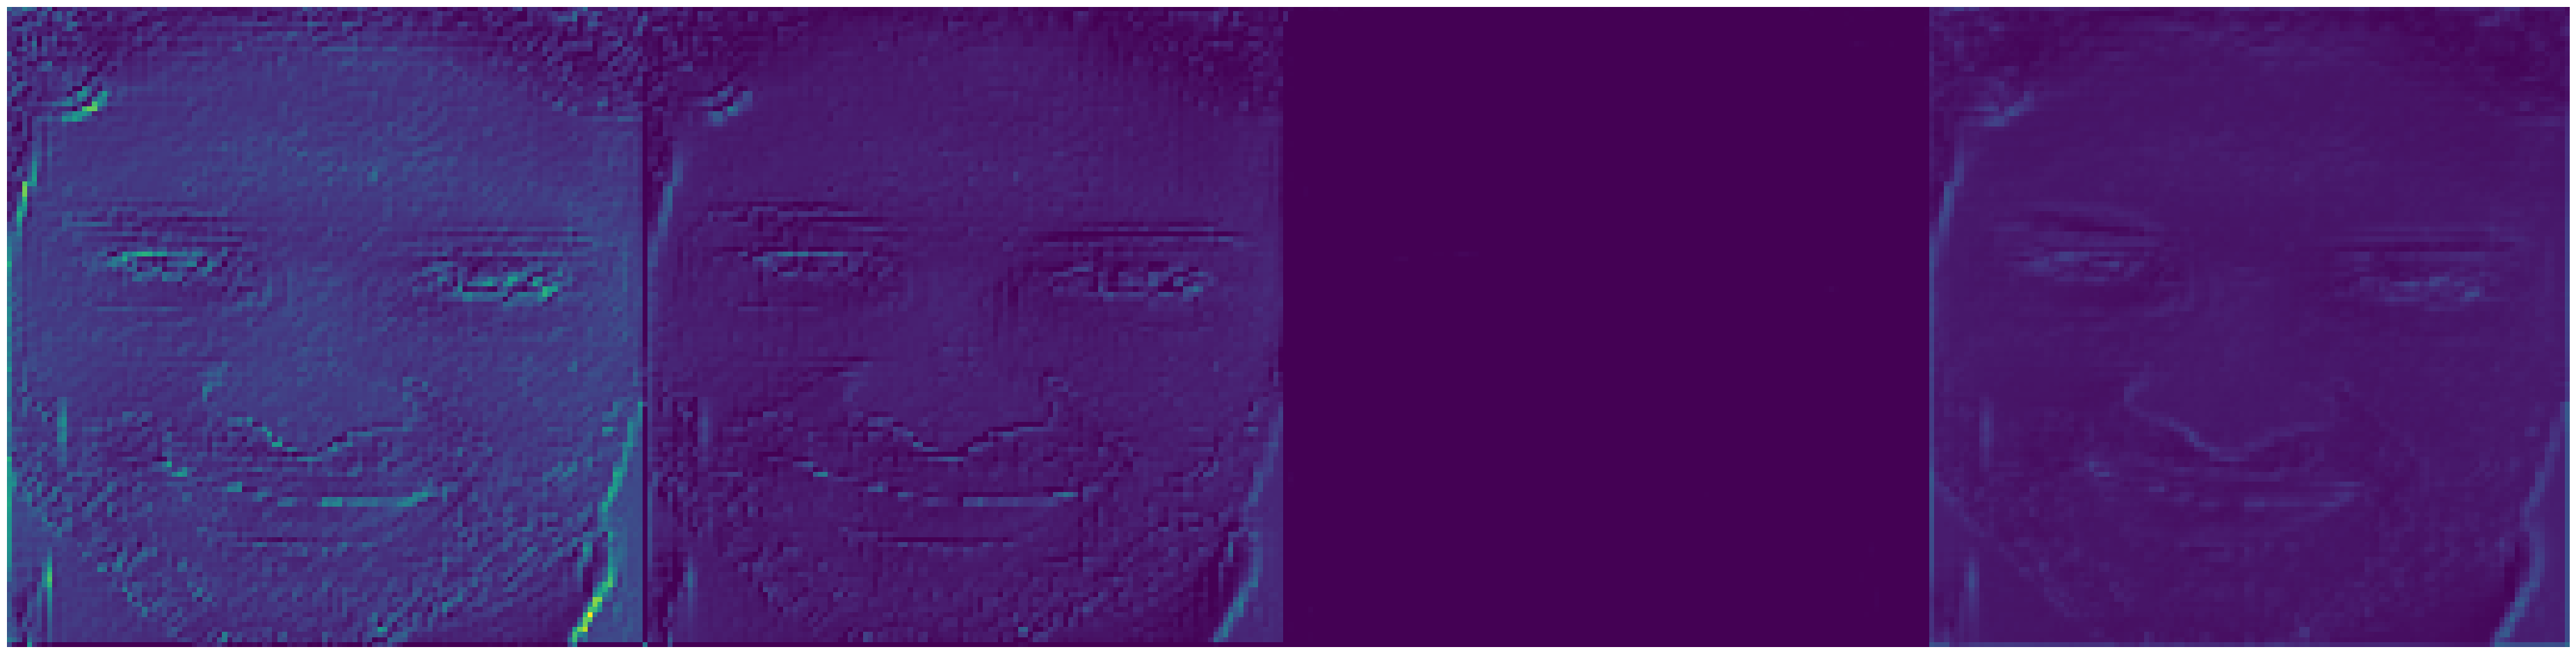

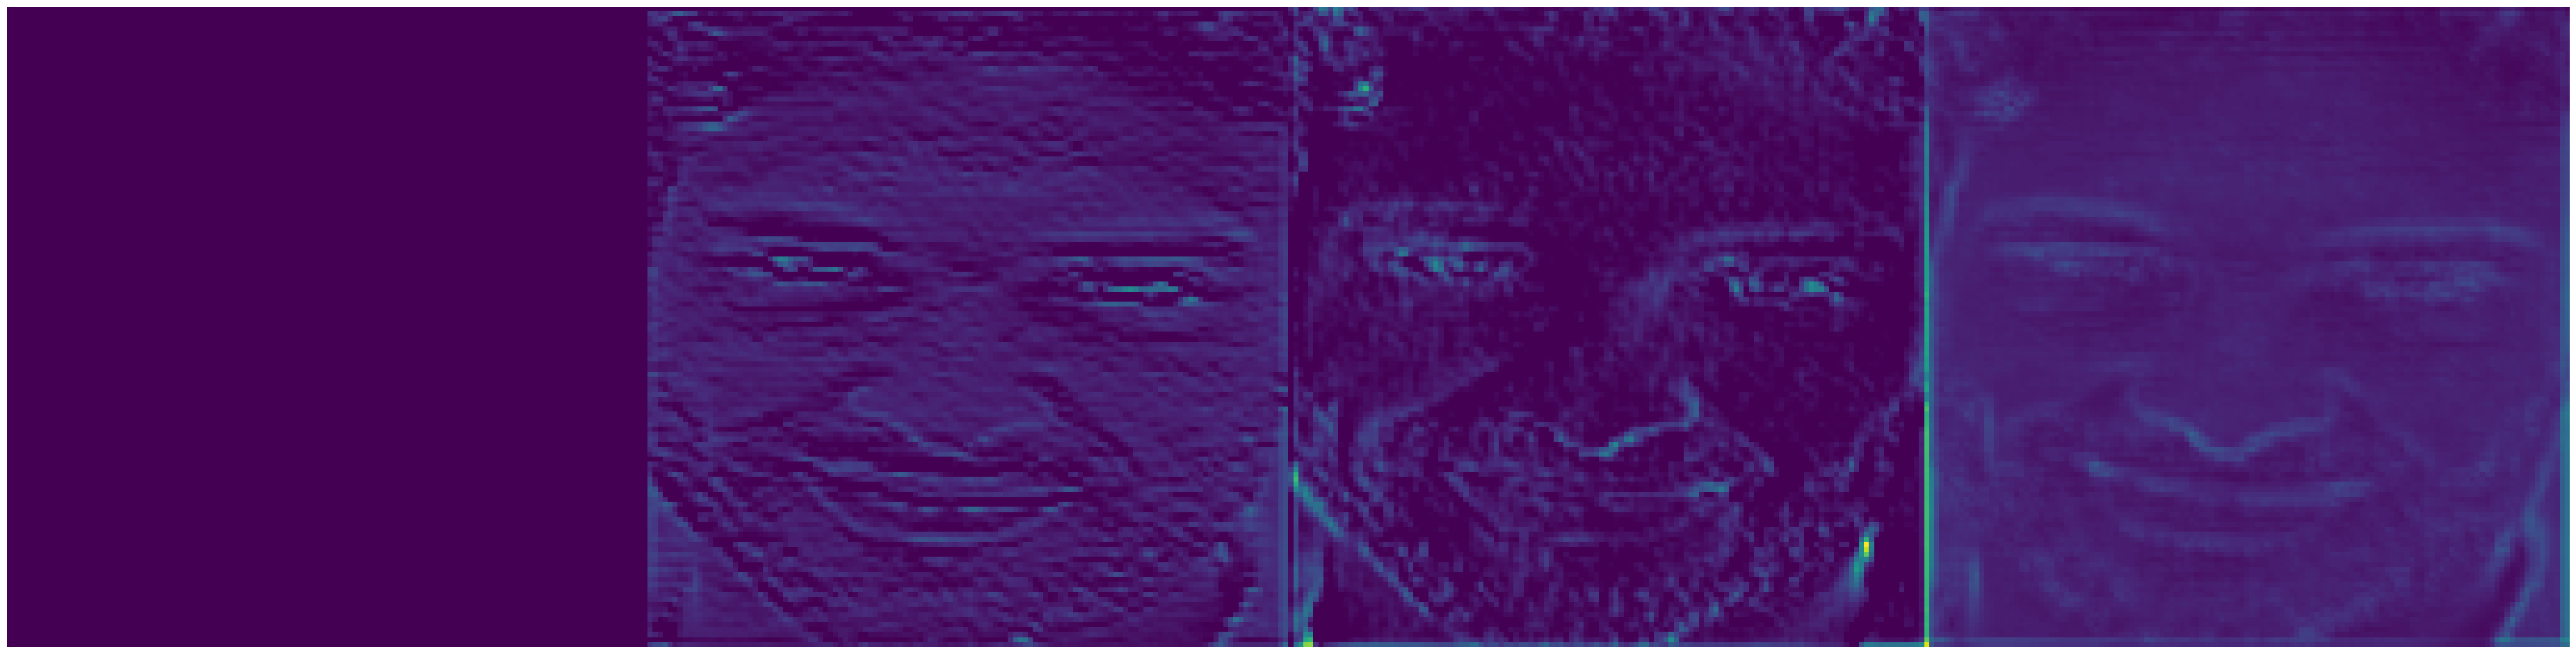

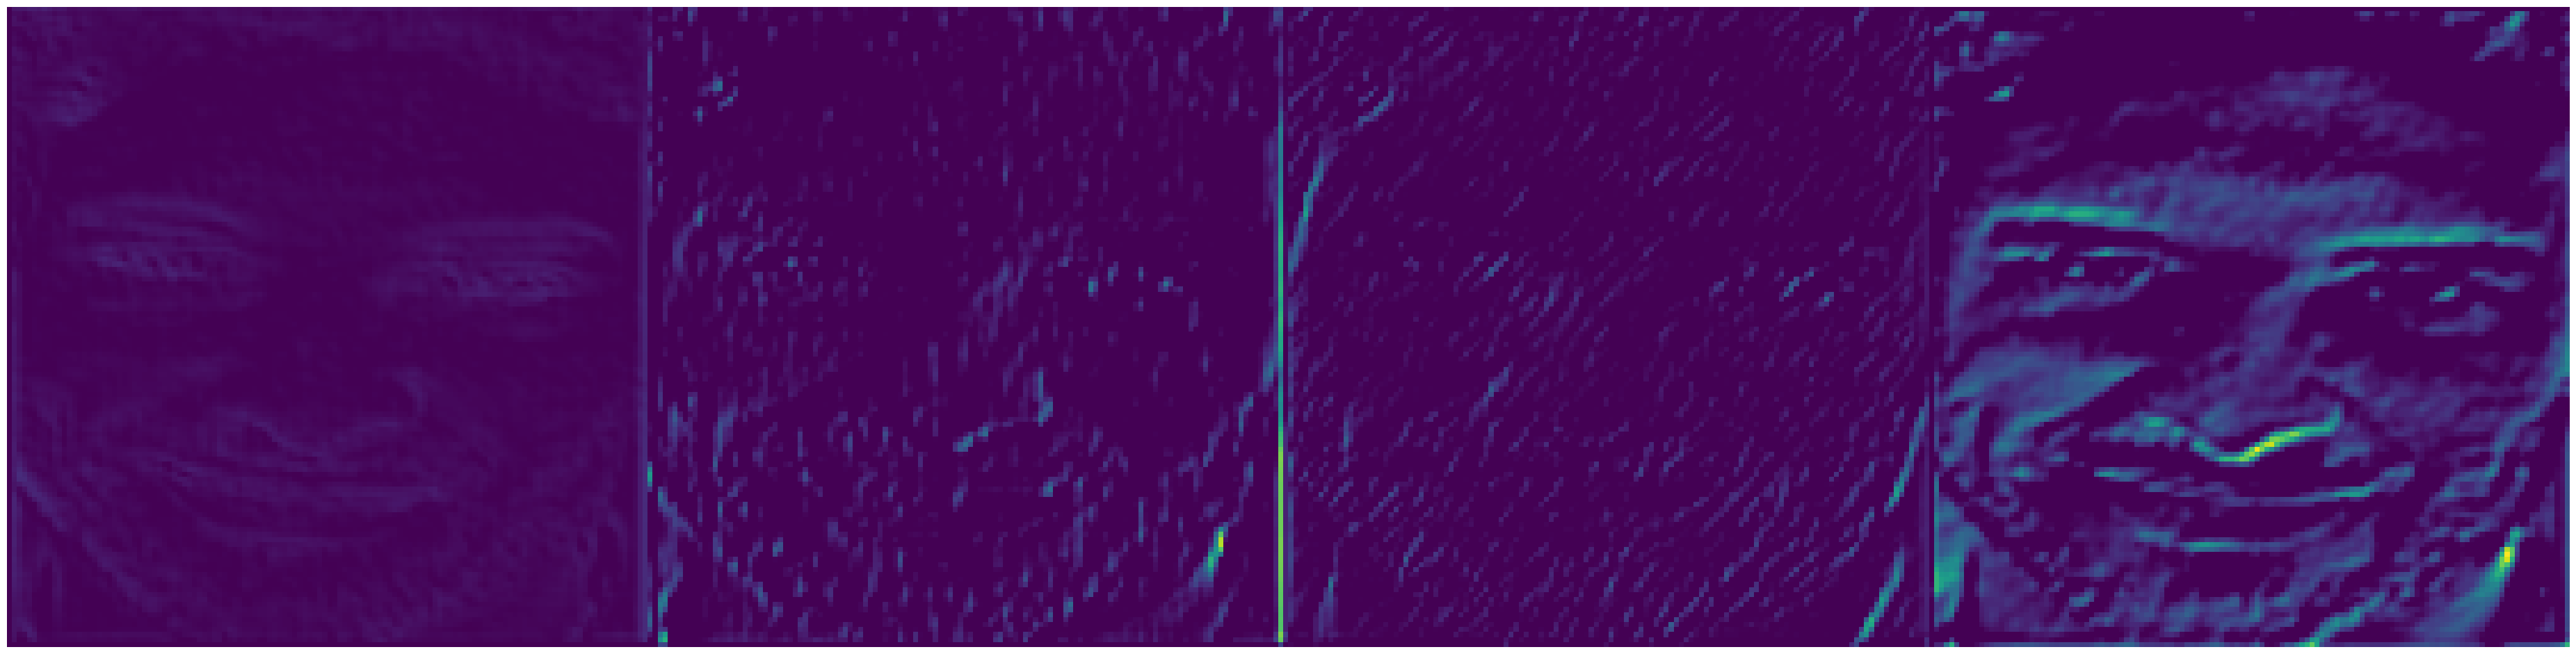

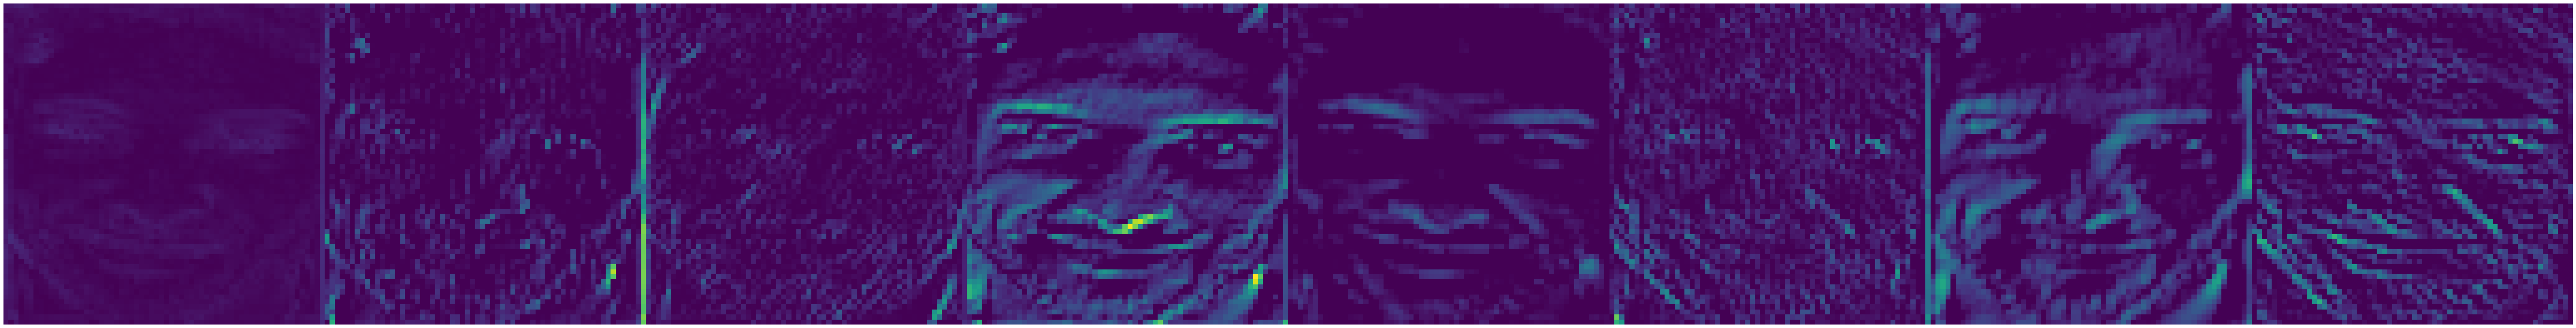

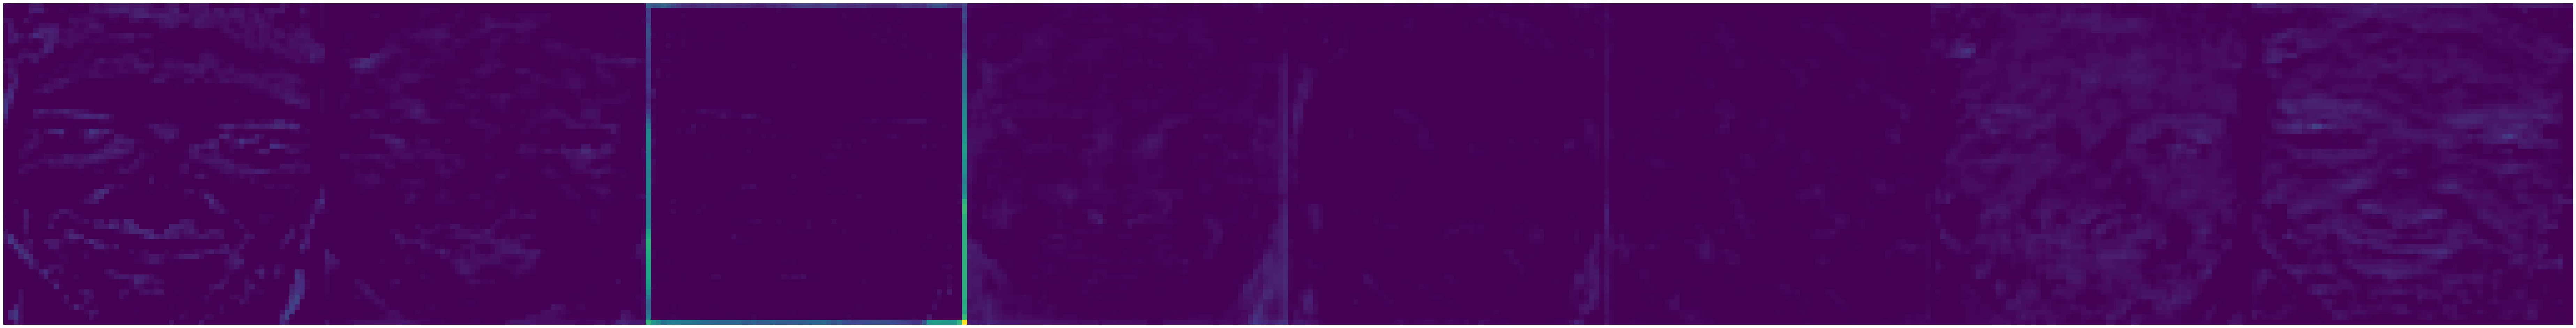

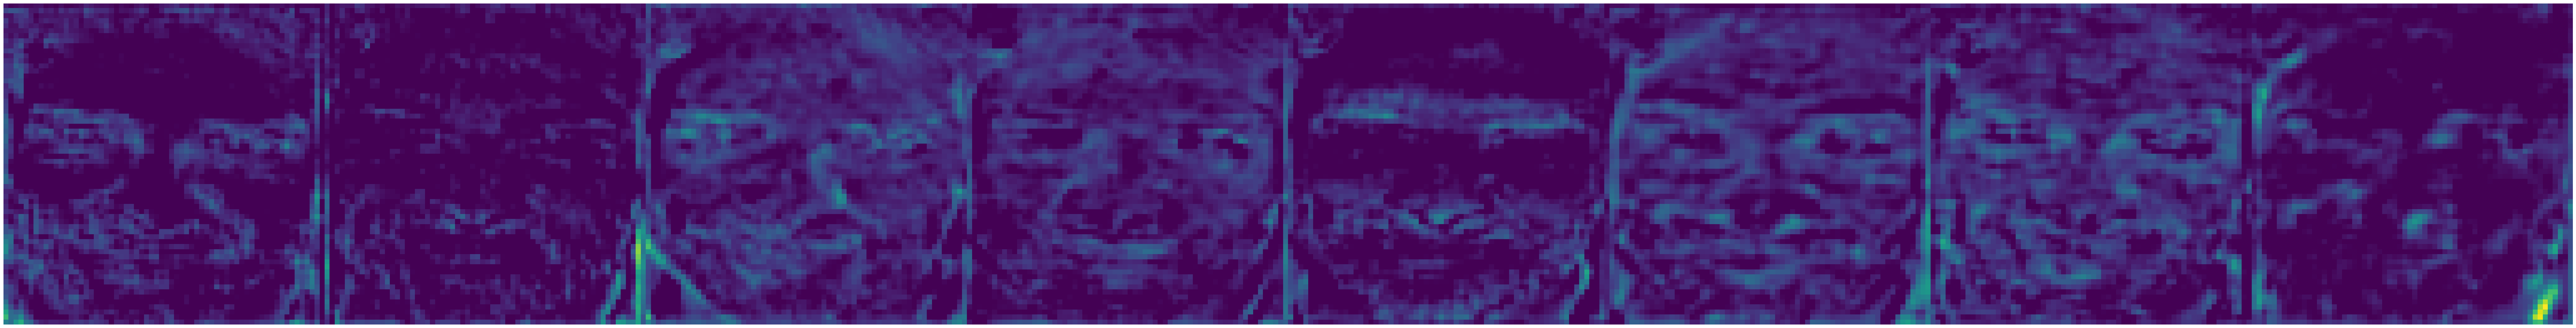

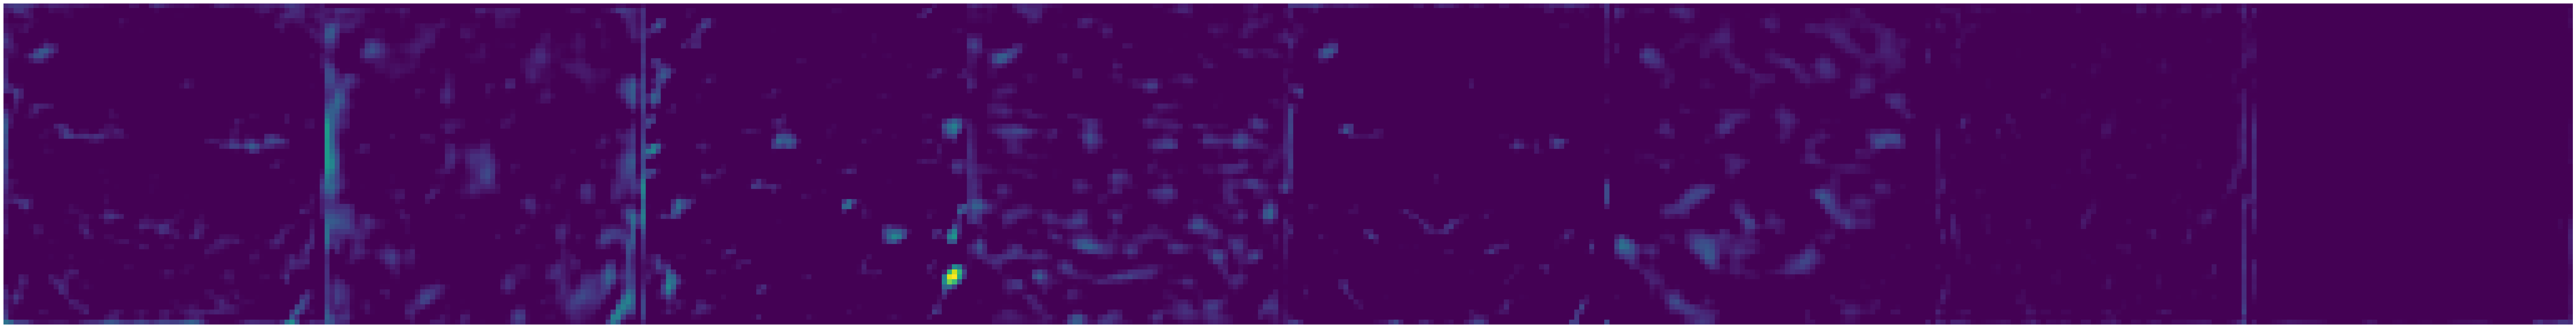

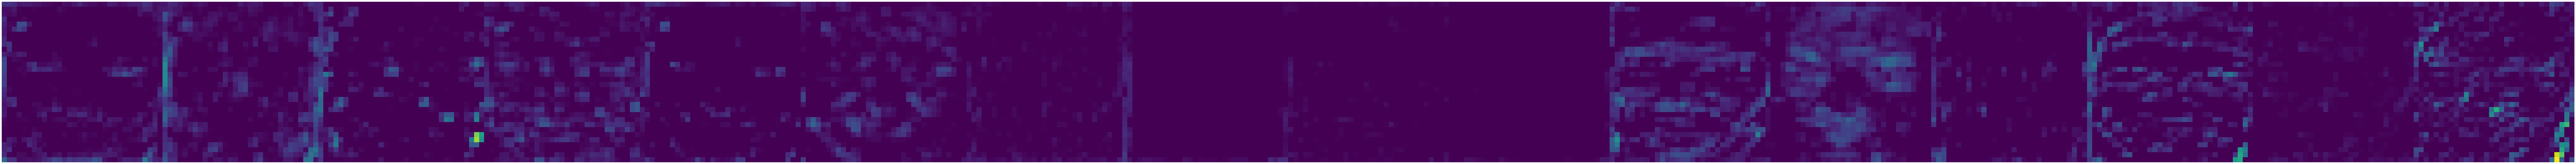

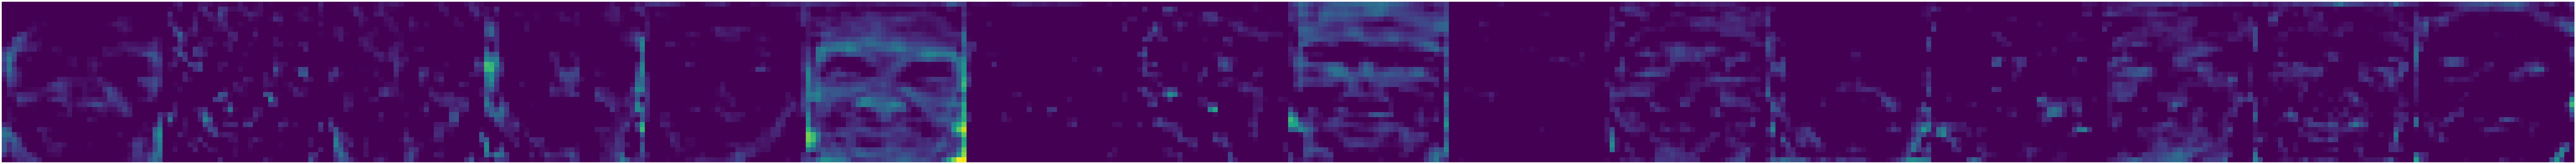

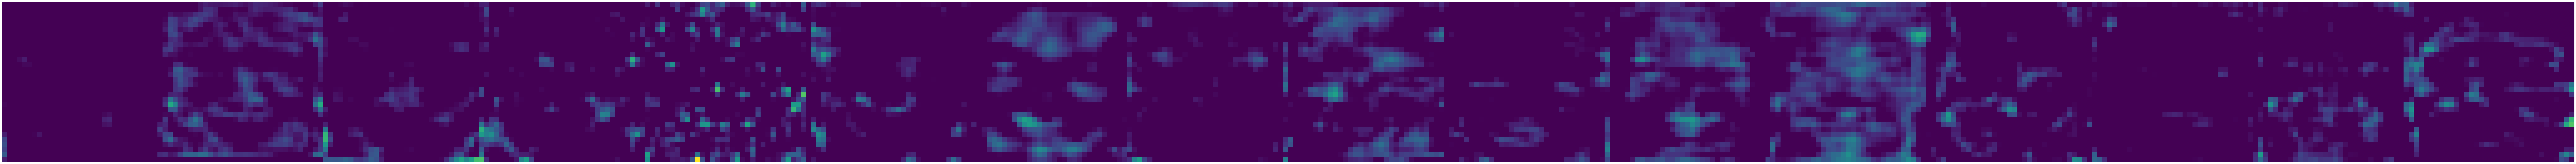

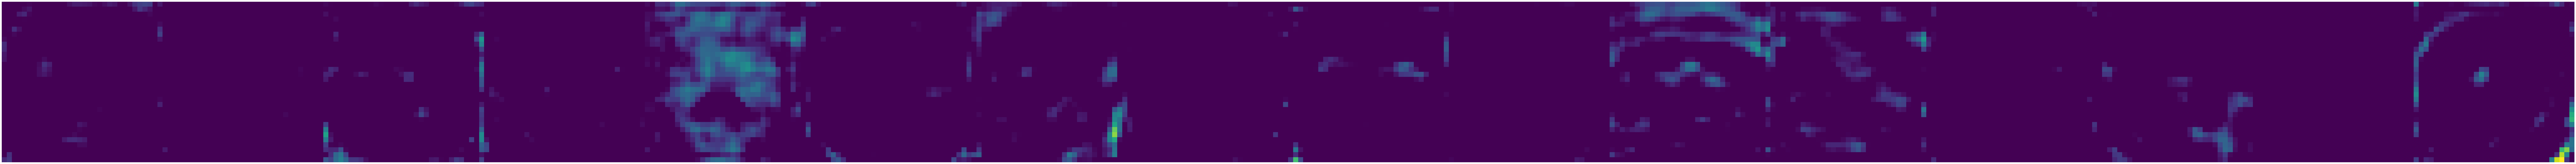

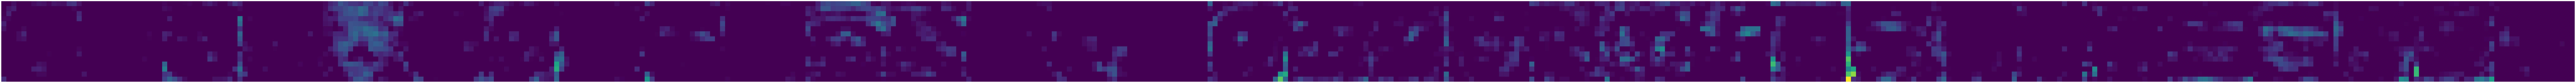

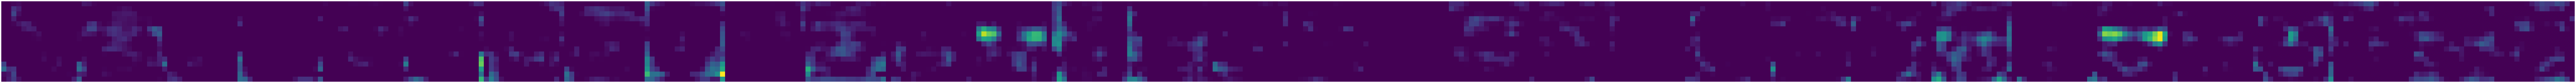

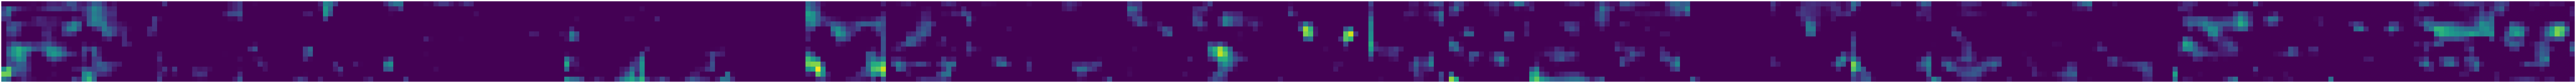

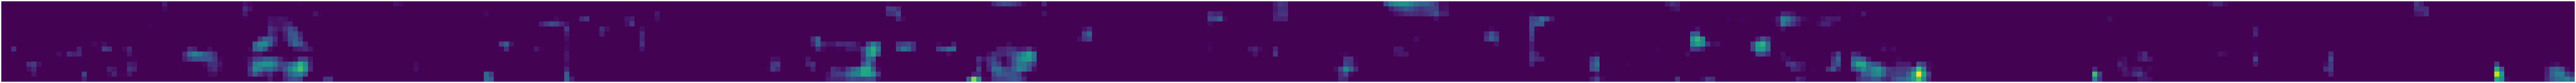

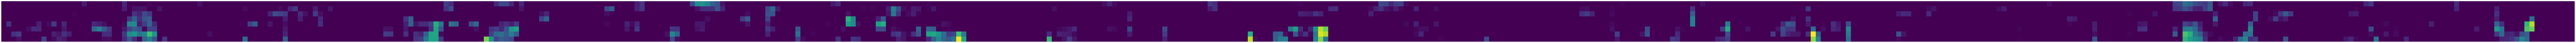

In [102]:
for i in range(len(f_maps)):
    plt.figure(figsize=(256,256))
    f_size = f_maps[i].shape[1]
    n_channels = f_maps[i].shape[3]
    joint_maps = np.ones((f_size,f_size*n_channels))

    axs = plt.subplot(len(f_maps),1,i+1)

    for j in range(n_channels):
        joint_maps[:,f_size*j:f_size*(j+1)] = f_maps[i][...,j]
    plt.imshow(joint_maps[:,0:512])
    plt.axis('off')

## GradCam

In [28]:
new_backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
new_backbone.trainable=False

In [141]:
test_im = cv2.imread('21431.jpg_brightness_2.jpg')
if test_im is None:
    print(f"Error: Could not read the image from the path:")
test_im = cv2.resize(test_im,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = tf.constant(test_im , dtype = tf.float32)
im = tf.expand_dims(im,axis=0)



In [33]:
x = new_backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION['N_DENSE_1'],activation='relu')(x)
x = Dense(CONFIGURATION['N_DENSE_2'],activation='relu')(x)
output = Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax')(x)

pretrained_model = Model(new_backbone.inputs,output)
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 256, 256, 3)       │               7 │ rescaling_3[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 257, 257, 3)       │               0 │ rescaling_4[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 48)      │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 48)      │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 48)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 128, 128, 48)      │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 128, 128, 48)      │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 128, 128, 48)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 48)          │             62

 Total params: 30,743,290 (117.28 MB)

 Trainable params: 2,229,763 (8.51 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [41]:
 preds = pretrained_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [42]:
preds

array([[0.28538826, 0.42098138, 0.2936303 ]], dtype=float32)

In [45]:
np.argmax(preds[0])

1

In [47]:
last_conv_name = 'top_activation'
last_conv = pretrained_model.get_layer(last_conv_name)
last_conv_model = tf.keras.Model(pretrained_model.input,last_conv.output)

In [49]:
classifier_layer_names = [
 "global_average_pooling2d_1",
 "dense_3",
 "dense_4",
 "dense_5"
]

In [51]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [57]:
print(classifier_model(last_conv_model(im)))

tf.Tensor([[0.2853883  0.4209814  0.29363027]], shape=(1, 3), dtype=float32)


In [143]:
with tf.GradientTape() as tape:
  last_conv_output = last_conv_model(im)
  preds = classifier_model(last_conv_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_output)

tf.Tensor(1, shape=(), dtype=int64)


In [144]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [145]:
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)).numpy()

In [146]:
pooled_grads

array([-8.2959152e-05,  3.2408712e-05,  3.9723061e-05, ...,
       -1.0113683e-05,  1.6097398e-04,  9.0821522e-05], dtype=float32)

In [147]:
last_conv_output = last_conv_model(im)[0].numpy()
for i in range(2048):
    last_conv_output[:,:,i]*=pooled_grads[i]

In [148]:
heatmap = np.sum(last_conv_output,axis=-1)

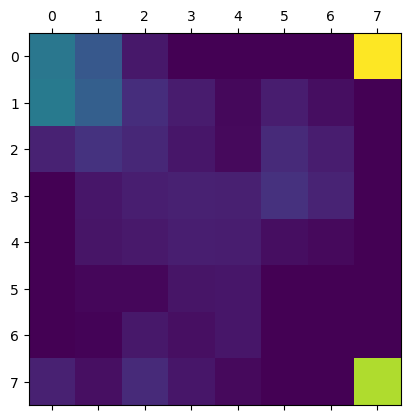

In [149]:
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

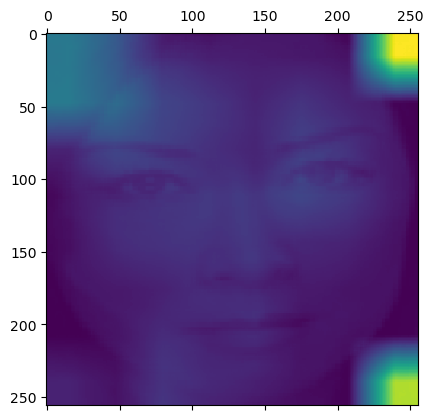

In [150]:
resized_heatmap = cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*500+ (im[0,:,:,0]/255))

## Vision Transformer

In [53]:
test_im = cv2.imread('21431.jpg_brightness_2.jpg')
if test_im is None:
    print(f"Error: Could not read the image from the path:")
test_im = cv2.resize(test_im,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

im = tf.constant(test_im , dtype = tf.float32)
im = tf.expand_dims(im,axis=0)

In [75]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_im,axis=0),
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [77]:
patches.shape

TensorShape([1, 16, 16, 768])

In [83]:
patches = tf.reshape(patches,(patches.shape[0],-1,768))
print(patches.shape)

(1, 256, 768)


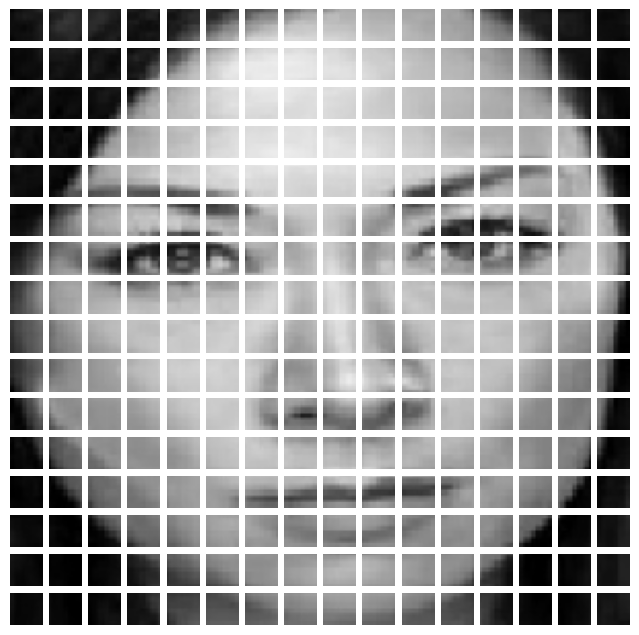

In [87]:
plt.figure(figsize=(8,8))
k=0
for i in range(256):
    
    ax=plt.subplot(16,16,k+1)
    plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
    plt.axis('off')
    k+=1

In [178]:
class PatchEncoder(Layer):
  def __init__(self,N_patches,Hidden_size):
      
      
      super(PatchEncoder, self).__init__(name = 'patch_encoder')

      self.linear_projection = Dense(Hidden_size)
      self.positional_embedding = Embedding(N_patches,Hidden_size)
      self.N_patches = N_patches


  def call(self, x):
      
      patches = tf.image.extract_patches(images=x,
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
      
      patches = tf.reshape(patches,(tf.shape(patches)[0],-1,patches.shape[-1]))
      embedding_input = tf.range(start =0,limit = self.N_patches)
      output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
      return output

In [179]:
patch_enc = PatchEncoder(256,768)
patch_enc(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[-0.02085793,  0.03977606, -0.0446121 , ..., -0.01623707,
         -0.04137043, -0.00098794],
        [ 0.03051538, -0.04351152,  0.04735449, ..., -0.02305881,
          0.03770325,  0.01835442],
        [-0.03049196, -0.02969649, -0.03620508, ..., -0.04289871,
          0.00803312, -0.04618145],
        ...,
        [ 0.02193037,  0.03577734,  0.04123538, ...,  0.03194222,
          0.01162331,  0.04426882],
        [-0.0155568 ,  0.01073937, -0.01336032, ...,  0.04589144,
          0.04673841,  0.0227756 ],
        [ 0.0354319 , -0.03248776,  0.01654195, ..., -0.01670765,
          0.00962681, -0.01717477]],

       [[-0.02085793,  0.03977606, -0.0446121 , ..., -0.01623707,
         -0.04137043, -0.00098794],
        [ 0.03051538, -0.04351152,  0.04735449, ..., -0.02305881,
          0.03770325,  0.01835442],
        [-0.03049196, -0.02969649, -0.03620508, ..., -0.04289871,
          0.00803312, -0.04618145],
        ...

In [180]:
class TransformerEncoder(Layer):
  def __init__(self,N_heads,Hidden_size):
      
      
      super(TransformerEncoder, self).__init__(name = 'Transformer_encoder')

      self.layer_norm1 = LayerNormalization()
      self.layer_norm2 = LayerNormalization()
      self.multihead = MultiHeadAttention(N_heads,Hidden_size)
      self.dense1 = Dense(Hidden_size , activation= tf.nn.gelu)
      self.dense2 = Dense(Hidden_size , activation= tf.nn.gelu)


  def call(self, input):
      x_1 = self.layer_norm1(input)
      x_1 = self.multihead(x_1,x_1)
      x_1 = Add()([x_1,input])

      x_2 = self.layer_norm2(x_1)
      x_2 = self.dense1(x_2)
      output = self.dense2(x_2)
      output = Add()([x_1,output])
      
      return output

In [181]:
trans_enc = TransformerEncoder(8,768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [182]:
class ViT(Model):
  def __init__(self,N_heads,Hidden_size,N_patches,N_layers,N_dense):
      
      super(ViT, self).__init__(name = 'vision_transformer')
      self.N_layers = N_layers
      self.patch_encoder = PatchEncoder(N_patches,Hidden_size)
      self.trans_encoders = [ TransformerEncoder(N_heads,Hidden_size)for _ in range(N_layers)]
      self.dense1 = Dense(N_dense,tf.nn.gelu)
      self.dense2 = Dense(N_dense,tf.nn.gelu)
      self.dense3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')


  def call(self, input, training = True):
      
      x = self.patch_encoder(input)
      for i in range(self.N_layers):
          x = self.trans_encoders[i](x)
      x = Flatten()(x)
      x = self.dense1(x)
      x = self.dense2(x)
      
      return self.dense3(x)

In [183]:
vit = ViT(N_heads=4,Hidden_size=768,N_patches=256,N_layers=2,N_dense=128)
vit(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
       [0.52135676, 0.2979107 , 0.1807326 ],
      

In [184]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)         │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (32, 128)                   │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (32, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [185]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [186]:
vit.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
  loss = CategoricalCrossentropy(),
  metrics = metrics,
)

In [187]:
history=vit.fit( 
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/5
 12/213 ━━━━━━━━━━━━━━━━━━━━ 17:29 5s/step - accuracy: 0.3331 - loss: 1037094.6875 - top_k_accuracy: 1.0000

KeyboardInterrupt: 

## HuggingFace Transformers

In [18]:
from transformers import AutoImageProcessor, TFViTModel

model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (224,224,3))
x = base_model.vit(inputs)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\adity\anaconda3\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.